<a href="https://colab.research.google.com/github/Droslj/scATAC-seq-complete-/blob/Google-colab/scATAC_seq_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

scATAC seq, based on scATAC seq processing Galaxy tutorials (scATAC preprocessing (2), Standard scATAC seq processing pipeline (1) )
AD Objects created in Galaxy using customized Galaxy WF with Snapatac2 and imported
(1) https://usegalaxy.eu/training-material/topics/single-cell/tutorials/scatac-preprocessing-tenx/tutorial.html#mapping-reads-to-a-reference-genome, (2) https://usegalaxy.eu/training-material/topics/single-cell/tutorials/scatac-standard-processing-snapatac2/tutorial.html
Data taken from the following NCBI study:
Metabolic adaptation pilots the differentiation of human hematopoietic cells (https://www.ncbi.nlm.nih.gov/bioproject/PRJNA1015713)
Import Anndata objects for two biological replicates, SRR26046013 (cells treated with AOA inhibitor) and SRR26046019 (untreated cells)
Perform following steps:
(1) Import matrices
(2) Compute fragment size distribution
(3) Compute TSS enrichment
(4) Filter cell counts based on TSSe
(5) Create cell by bin matrix based on 500 bp wide bins accross the whole genome
(6) Perform feature selection
(7) Perform Doublet removal
(8) Perform Dim reduction (spectral)
(9) Perform Clustering (neighborhood, UMAP, leiden)
(10) Create a cell by gene matrix
(11) Concatenate matrices using Inner join
(12) Remove batch effects

In [2]:
!pip install -q condacolab

In [3]:
import condacolab

In [4]:
condacolab.install()

✨🍰✨ Everything looks OK!


In [5]:
!conda --version

conda 23.11.0


In [6]:
!which conda

/usr/local/bin/conda


In [7]:
!conda config --add channels conda-forge

In [8]:
!conda config --add channels bioconda

In [9]:
!pip install snapatac2 -q

In [10]:
!pip show snapatac2

Name: snapatac2
Version: 2.8.0
Summary: SnapATAC2: Single-cell epigenomics analysis pipeline
Home-page: https://github.com/
Author: Kai Zhang <kai@kzhang.org>
Author-email: Kai Zhang <zhangkai33@westlake.edu.cn>
License: MIT
Location: /usr/local/lib/python3.10/site-packages
Requires: anndata, igraph, kaleido, macs3, multiprocess, natsort, numpy, pandas, plotly, polars, pooch, pyarrow, pyfaidx, rustworkx, scikit-learn, scipy, tqdm, typeguard
Required-by: 


In [11]:
import snapatac2 as snap

In [12]:
!pip install umap-learn



In [13]:
import umap.umap_ as umap


In [14]:
from umap import UMAP

In [15]:
!pip install scanpy -q

In [16]:
import scanpy as sc

In [17]:
pip show scanpy

Name: scanpy
Version: 1.10.4
Summary: Single-Cell Analysis in Python.
Home-page: 
Author: Alex Wolf, Philipp Angerer, Fidel Ramirez, Isaac Virshup, Sergei Rybakov, Gokcen Eraslan, Tom White, Malte Luecken, Davide Cittaro, Tobias Callies, Marius Lange, Andrés R. Muñoz-Rojas
Author-email: 
License: 
Location: /usr/local/lib/python3.10/site-packages
Requires: anndata, h5py, joblib, legacy-api-wrap, matplotlib, natsort, networkx, numba, numpy, packaging, pandas, patsy, pynndescent, scikit-learn, scipy, seaborn, session-info, statsmodels, tqdm, umap-learn
Required-by: 


In [18]:
import numpy as np

In [19]:
import anndata as ad

In [20]:
!pip install diffxpy -q

In [21]:
import diffxpy.api as de

In [22]:
import matplotlib.pyplot as plt

In [23]:
import seaborn as sns

In [24]:
import plotly.subplots as sp
import plotly.graph_objects as go

In [25]:
from scipy import stats

In [26]:
import pandas as pd

# Import reads from google drive, three samples treated with energy metabolism inhibitors and one untreated

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
#Load AD matrix from google drive, PCA and Batch corrected
adata_concat = sc.read_h5ad('/content/drive/MyDrive/Colab Notebooks/MTXmerged_PCA_BC.h5ad')

/usr/local/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Plot the 'obsm' before and after batch effect removal (PC1 vs PC2)

In [29]:
#Extract data sets
x_before = adata_concat.obsm['X_pca'][:, 0]
y_before = adata_concat.obsm['X_pca'][:, 1]

x_after = adata_concat.obsm['X_pca_harmony'][:, 0]
y_after = adata_concat.obsm['X_pca_harmony'][:, 1]
batch_labels = adata_concat.obs['Treatment']


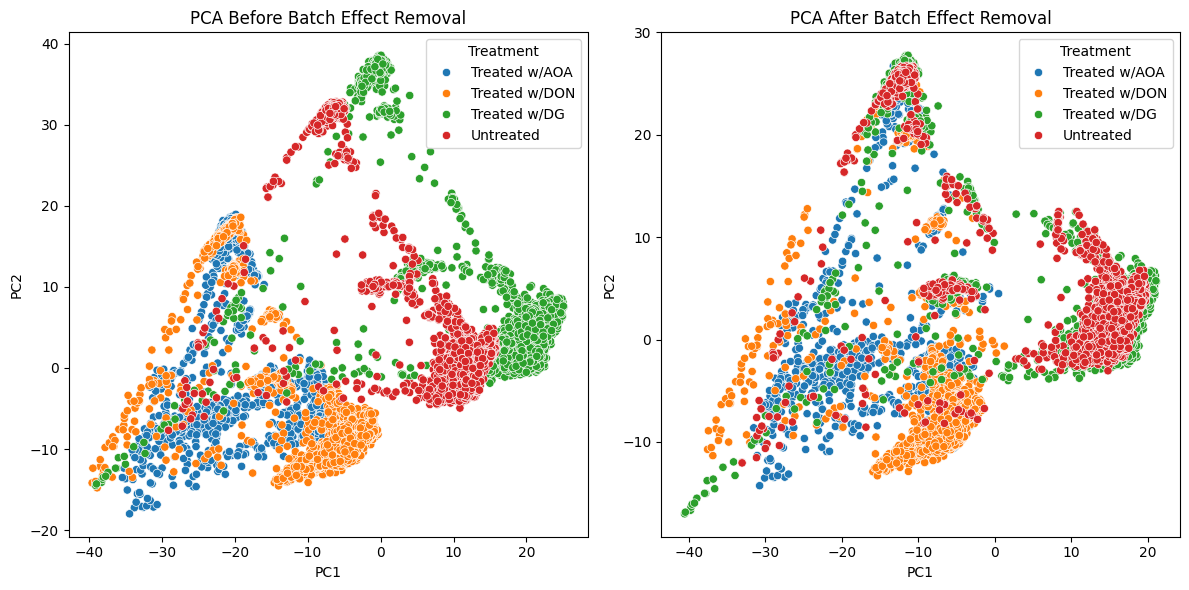

In [30]:
#Define figure
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
#Plot before batch effect removal

sns.scatterplot(x=x_before, y=y_before, hue=batch_labels)
plt.title('PCA Before Batch Effect Removal')
plt.xlabel('PC1')
plt.ylabel('PC2')

#Plot PCA after batch effect removal

plt.subplot(1, 2, 2)
sns.scatterplot(x=x_after, y=y_after, hue=batch_labels)
plt.title('PCA After Batch Effect Removal')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.tight_layout()
plt.show()

In [31]:
#from shutil import copyfile
#copyfile('adata_concat.h5ad', '/content/drive/MyDrive/Colab Notebooks/adata_concat.h5ad')

In [32]:
adata_concat

AnnData object with n_obs × n_vars = 21361 × 53017
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden', 'Treatment'
    uns: 'pca'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'

# Differential accesibility analysis

In [33]:
# Perform differential accessibility testing with Wilcoxon rank-sum test
sc.tl.rank_genes_groups(adata_concat, 'Treatment', method='wilcoxon')

In [34]:
# Access results in `adata_concat.uns['rank_genes_groups']`
# For example, to get the top differentially accessible regions:
top_dars = sc.get.rank_genes_groups_df(adata_concat, group='Treated w/AOA', pval_cutoff=0.05)

In [35]:
top_dars

,names,scores,logfoldchanges,pvals,pvals_adj
0,LINC01686,11.140080,0.387329,8.004735e-29,4.263054e-28
1,SATB1,10.738822,0.262134,6.689235e-27,3.368251e-26
2,LRRN3,10.288052,0.659100,7.977435e-25,3.778946e-24
3,LEF1,10.168393,0.363969,2.743984e-24,1.277466e-23
4,CD3D,9.889269,1.128489,4.633991e-23,2.076932e-22
...,...,...,...,...,...
27797,CNTNAP2,-47.828995,-1.124444,0.000000e+00,0.000000e+00
27798,CDH23,-47.958527,-0.664805,0.000000e+00,0.000000e+00
27799,MSI2,-48.331894,-0.729379,0.000000e+00,0.000000e+00
27800,RBFOX1,-49.328617,-1.324195,0.000000e+00,0.000000e+00


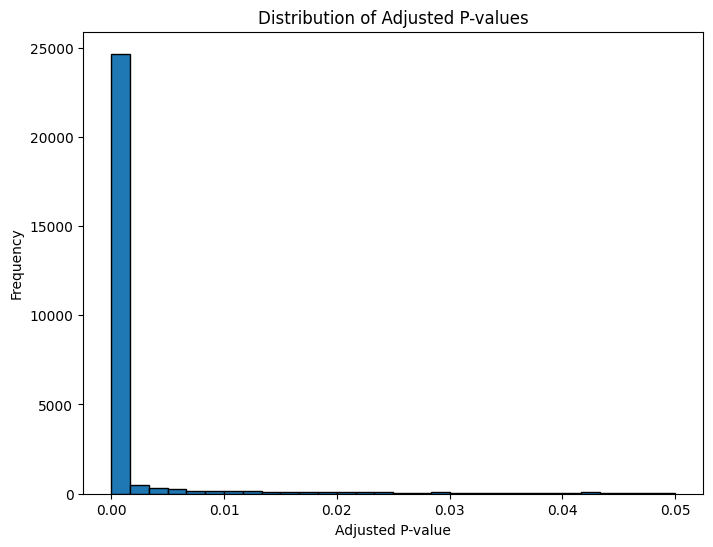

In [36]:
#Distribution of Adjusted P-values

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.hist(top_dars['pvals_adj'], bins=30, edgecolor='black')
plt.title('Distribution of Adjusted P-values')
plt.xlabel('Adjusted P-value')
_ = plt.ylabel('Frequency')

In [37]:
# Sort by adjusted p-value in ascending order (most significant first)
top_dars_sorted = top_dars.sort_values(by='pvals_adj')

# Select the top 10 rows
top_10_dars = top_dars_sorted.head(10)
bottom_10_dars = top_dars_sorted.tail(10)

In [38]:
# Display the top 10 DARs
print(top_10_dars)

                 names     scores  logfoldchanges  pvals  pvals_adj
27801            ZMIZ1 -52.757572       -0.801663    0.0        0.0
27720        IL12A-AS1 -39.203812       -0.853888    0.0        0.0
27721  ENSG00000283563 -39.211956       -0.724741    0.0        0.0
27722            KDM4B -39.223949       -0.668567    0.0        0.0
27723           INPP5A -39.293507       -0.600778    0.0        0.0
27724  ENSG00000258344 -39.321419       -0.604507    0.0        0.0
27725             SUFU -39.419426       -0.636987    0.0        0.0
27726  ENSG00000230773 -39.501812       -0.656824    0.0        0.0
27727             DLC1 -39.522858       -0.956882    0.0        0.0
27728            RBMS3 -39.539345       -0.894024    0.0        0.0


In [39]:
print(bottom_10_dars)

               names    scores  logfoldchanges     pvals  pvals_adj
289           NANOS2 -2.226390       -1.051699  0.025988   0.049574
288  ENSG00000289068 -2.226055       -0.639451  0.026010   0.049615
287           MRGPRG -2.225368       -1.574157  0.026057   0.049701
286        RNU6-163P -2.225322       -0.660606  0.026060   0.049705
285        LINC02387 -2.225267       -0.825357  0.026063   0.049710
284           PPP3CC -2.225226       -0.065779  0.026066   0.049714
283        RPL21P126 -2.225075       -1.059356  0.026076   0.049731
282         C6orf163 -2.224730       -0.845233  0.026099   0.049774
281           NDUFA1 -2.223986       -0.120385  0.026149   0.049867
280  ENSG00000224810 -2.222990       -0.678497  0.026217   0.049994


/usr/local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


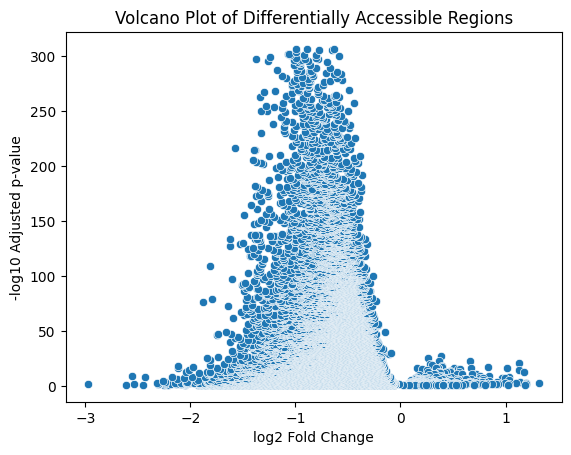

In [40]:
# Create scatterplot of differential accessibility results
sns.scatterplot(x=top_dars['logfoldchanges'], y=-np.log10(top_dars['pvals_adj']))
plt.xlabel('log2 Fold Change')
plt.ylabel('-log10 Adjusted p-value')
plt.title('Volcano Plot of Differentially Accessible Regions')
plt.show()

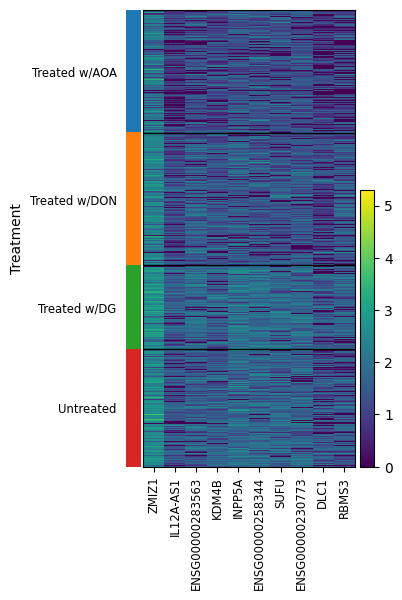

In [41]:
#Heatmap of top 10 differentially most expressed genes
sc.pl.heatmap(adata_concat, top_10_dars['names'].tolist(), groupby='Treatment', cmap='viridis')

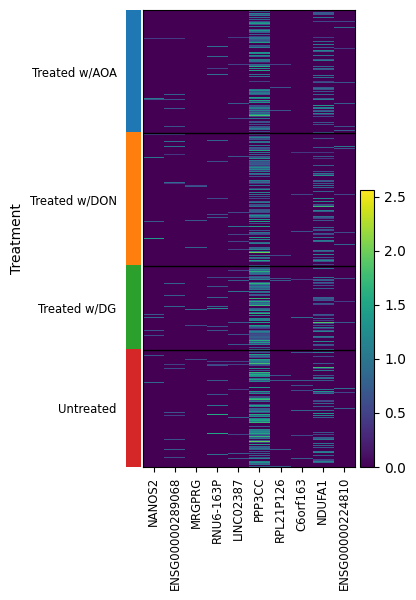

In [42]:
#Heatmap of top 10 differentially lowest expressed genes
sc.pl.heatmap(adata_concat, bottom_10_dars['names'].tolist(), groupby='Treatment', cmap='viridis')

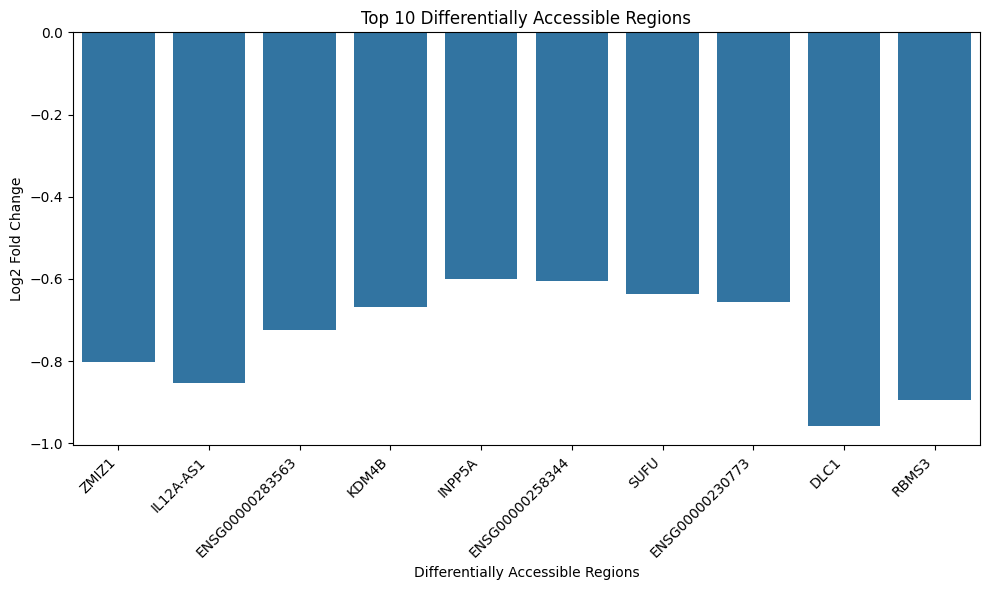

In [43]:
# Create a bar plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
sns.barplot(x=top_10_dars['names'].tolist(), y=top_10_dars['logfoldchanges'])
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.xlabel('Differentially Accessible Regions')
plt.ylabel('Log2 Fold Change')
plt.title('Top 10 Differentially Accessible Regions')
plt.tight_layout()
plt.show()

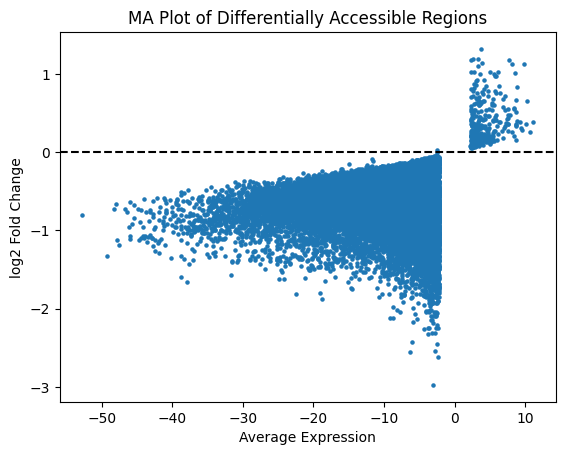

In [44]:
import matplotlib.pyplot as plt

# Assuming 'res_df' is your DataFrame of differential accessibility results
plt.scatter(top_dars['scores'], top_dars['logfoldchanges'], s=5)
plt.xlabel('Average Expression')
plt.ylabel('log2 Fold Change')
plt.title('MA Plot of Differentially Accessible Regions')
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

In [45]:
adata_concat.var_names

Index(['DDX11L1', 'WASH7P', 'ENSG00000238009', 'ENSG00000239945', 'DDX11L17',
       'WASH9P', 'ENSG00000228463', 'ENSG00000286448', 'U6', 'ENSG00000230021',
       ...
       'MT-ND4', 'MT-TH', 'MT-TS2', 'MT-TL2', 'MT-ND5', 'MT-ND6', 'MT-TE',
       'MT-CYB', 'MT-TT', 'MT-TP'],
      dtype='object', length=53017)

Generating violin plots:   0%|          | 0/10 [00:00<?, ?it/s]

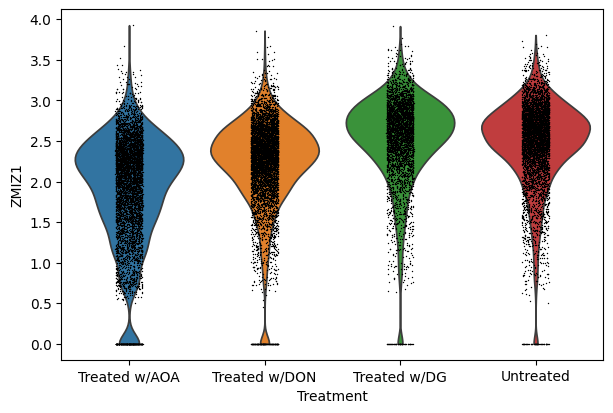

Generating violin plots:  10%|█         | 1/10 [00:01<00:10,  1.17s/it]

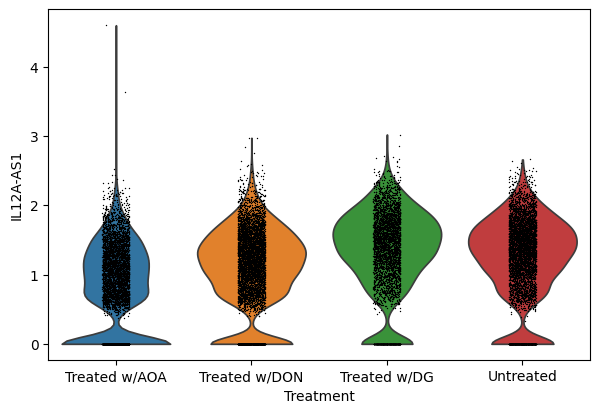

Generating violin plots:  20%|██        | 2/10 [00:02<00:09,  1.16s/it]

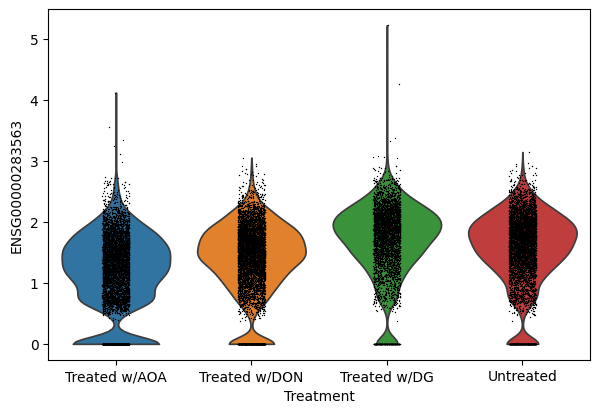

Generating violin plots:  30%|███       | 3/10 [00:03<00:08,  1.16s/it]

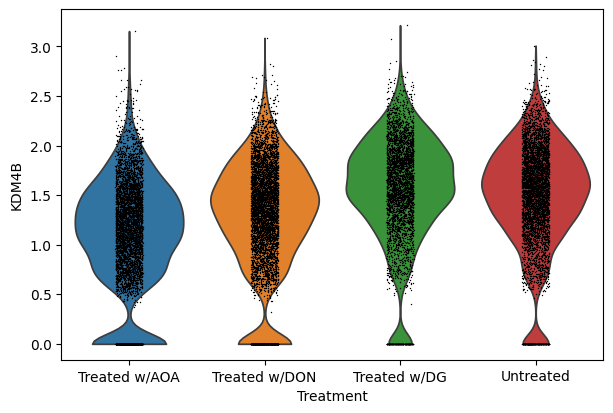

Generating violin plots:  40%|████      | 4/10 [00:04<00:06,  1.14s/it]

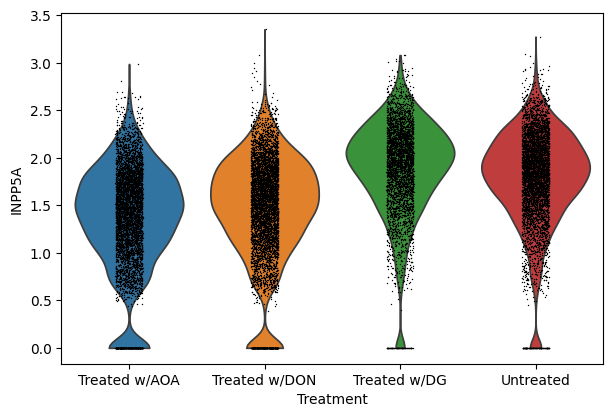

Generating violin plots:  50%|█████     | 5/10 [00:05<00:05,  1.12s/it]

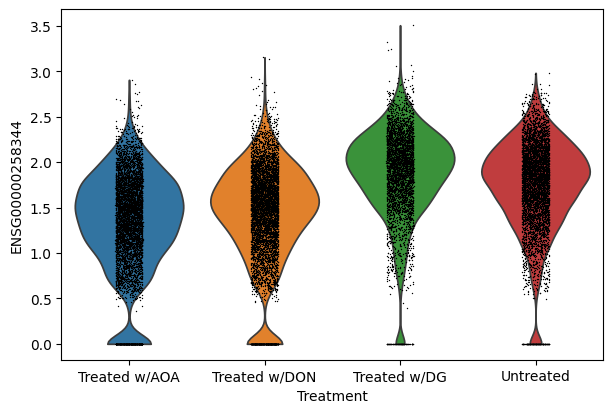

Generating violin plots:  60%|██████    | 6/10 [00:06<00:04,  1.12s/it]

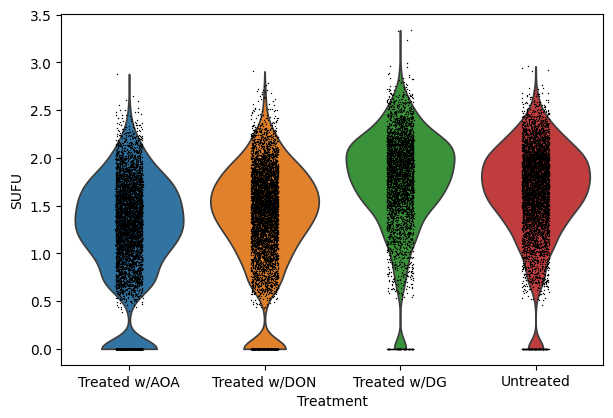

Generating violin plots:  70%|███████   | 7/10 [00:07<00:03,  1.11s/it]

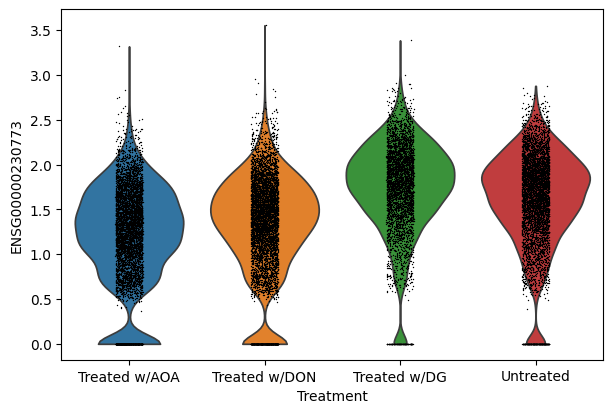

Generating violin plots:  80%|████████  | 8/10 [00:09<00:02,  1.11s/it]

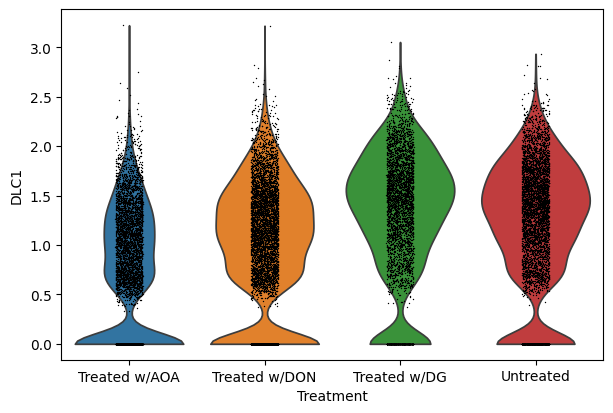

Generating violin plots:  90%|█████████ | 9/10 [00:10<00:01,  1.11s/it]

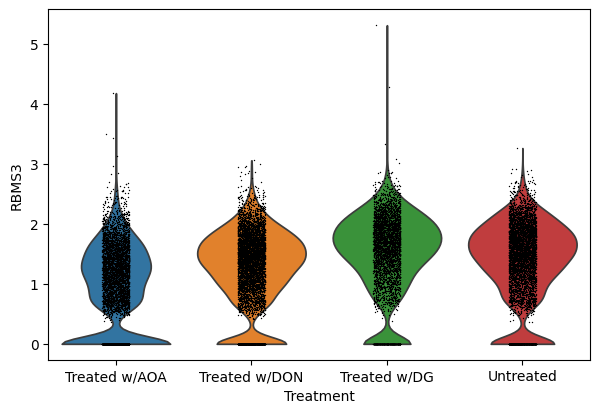

Generating violin plots: 100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


In [46]:
from tqdm import tqdm

for gene in tqdm(top_10_dars['names'].tolist(), desc="Generating violin plots"):
    sc.pl.violin(adata_concat, [gene], groupby='Treatment')

# Differential accessibility analysis using diffxpy

In [47]:
adata_concat.obs

,n_fragment,frac_dup,frac_mito,tsse,doublet_probability,doublet_score,leiden,Treatment
AAACAACGAACGAGCA,20919,0.502426,0.000096,25.061425,0.052336,0.047059,7,Treated w/AOA
AAACAACGAAGAGGCT,13308,0.488184,0.000826,23.198793,0.066163,0.009174,4,Treated w/AOA
AAACAACGAAGTCGGA,17302,0.502830,0.000058,18.234291,0.061446,0.015294,5,Treated w/AOA
AAACAACGAGAAGGCT,14109,0.530246,0.000071,29.930591,0.070621,0.004525,0,Treated w/AOA
AAACAACGAGTACGTT,12165,0.588867,0.000000,21.409091,0.062457,0.013841,7,Treated w/AOA
...,...,...,...,...,...,...,...,...
TTTGGGATGAACGTAA,33918,0.336626,0.001766,18.594706,0.185808,0.043189,1,Untreated
TTTGGGATGAAGTCTC,25630,0.307834,0.000117,15.581623,0.221046,0.025360,7,Untreated
TTTGGGATGATGTGGG,28438,0.336774,0.001019,19.425019,0.189493,0.040388,0,Untreated
TTTGGGATGCTCACGG,20103,0.336676,0.000149,26.203209,0.265871,0.012835,4,Untreated


In [48]:
# Check if the number of unique gene names is equal to the total number of gene names
is_unique = len(adata_concat.var_names) == pd.Series(adata_concat.var_names).nunique()

if is_unique:
    print("var_names are unique.")
else:
    print("var_names are not unique.")

var_names are unique.


In [49]:
# Check if any gene names are duplicated
has_duplicates = adata_concat.var_names.duplicated().any()

if has_duplicates:
    print("var_names are not unique.")
else:
    print("var_names are unique.")

var_names are unique.


In [50]:
import pandas as pd

# Check if the number of unique observations is equal to the total number of observations
is_unique = len(adata_concat.obs_names) == pd.Series(adata_concat.obs_names).nunique()

if is_unique:
    print("Observations are unique.")
else:
    print("Observations are not unique.")

Observations are not unique.


In [51]:
# Check if any observations are duplicated
has_duplicates = adata_concat.obs_names.duplicated().any()

if has_duplicates:
    print("Observations are not unique.")
else:
    print("Observations are unique.")

Observations are not unique.


In [52]:
#numpy type aliases
np.float = float
np.int = int   #module 'numpy' has no attribute 'int'
np.object = object    #module 'numpy' has no attribute 'object'
np.bool = bool    #module 'numpy' has no attribute 'bool'

# Make observation names unique



In [53]:
import dask.array as da

In [54]:
import scipy.sparse as sparse

In [70]:
import pandas as pd

# Reload the original Anndata object
adata_concat = sc.read_h5ad('/content/drive/MyDrive/Colab Notebooks/MTXmerged_PCA_BC.h5ad')

experiment_names = ["Treated w/AOA", "Treated w/DON", "Treated w/DG", "Untreated"]

# Create a new column to store combined barcode and treatment information
adata_concat.obs['barcode_treatment'] = adata_concat.obs_names.astype(str)

# Modify the 'barcode_treatment' column
for i, treatment in enumerate(experiment_names):
    cell_indices = adata_concat.obs.index[adata_concat.obs["Treatment"] == treatment]
    adata_concat.obs.loc[cell_indices, 'barcode_treatment'] = adata_concat.obs.loc[cell_indices, 'barcode_treatment'] + "_" + str(i + 1)

/usr/local/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [75]:
#Optionally set 'barcode_treatment' as the new index:
adata_concat.obs_names = pd.Index(adata_concat.obs['barcode_treatment'])

In [71]:
adata_concat

AnnData object with n_obs × n_vars = 21361 × 53017
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden', 'Treatment', 'barcode_treatment'
    uns: 'pca'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'

In [72]:
adata_concat.var_names

Index(['DDX11L1', 'WASH7P', 'ENSG00000238009', 'ENSG00000239945', 'DDX11L17',
       'WASH9P', 'ENSG00000228463', 'ENSG00000286448', 'U6', 'ENSG00000230021',
       ...
       'MT-ND4', 'MT-TH', 'MT-TS2', 'MT-TL2', 'MT-ND5', 'MT-ND6', 'MT-TE',
       'MT-CYB', 'MT-TT', 'MT-TP'],
      dtype='object', length=53017)

In [76]:
adata_concat.obs_names

Index(['AAACAACGAACGAGCA_1', 'AAACAACGAAGAGGCT_1', 'AAACAACGAAGTCGGA_1',
       'AAACAACGAGAAGGCT_1', 'AAACAACGAGTACGTT_1', 'AAACACGCTATCCTTT_1',
       'AAACACGCTCAGTCTA_1', 'AAACACGCTCATACTG_1', 'AAACACGCTCCAAACT_1',
       'AAACACGCTCTACTCC_1',
       ...
       'TTTGGGAACCGACATT_4', 'TTTGGGAACCGAGTGA_4', 'TTTGGGAACGAAGTTA_4',
       'TTTGGGAACTGACCTA_4', 'TTTGGGATGAACGCAG_4', 'TTTGGGATGAACGTAA_4',
       'TTTGGGATGAAGTCTC_4', 'TTTGGGATGATGTGGG_4', 'TTTGGGATGCTCACGG_4',
       'TTTGGGATGCTCTGGG_4'],
      dtype='object', name='barcode_treatment', length=21361)

# Run diffxpy wald test

In [ ]:
test = de.test.wald(
    data=adata_concat,
    formula_loc="~ 1 + Treatment",
    factor_loc_totest="Treatment"
)


training location model: False
training scale model: True
iter   0: ll=63915586792.117393
iter   1: ll=63915586792.117393, converged: 0.00% (loc: 100.00%, scale update: False), in 0.00sec
Fitting 53017 dispersion models: (progress not available with multiprocessing)